In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [13]:
df['Month'] = pd.to_datetime(df["Month"])

In [14]:
df.set_index("Month",inplace=True)

Text(0, 0.5, 'Passengers')

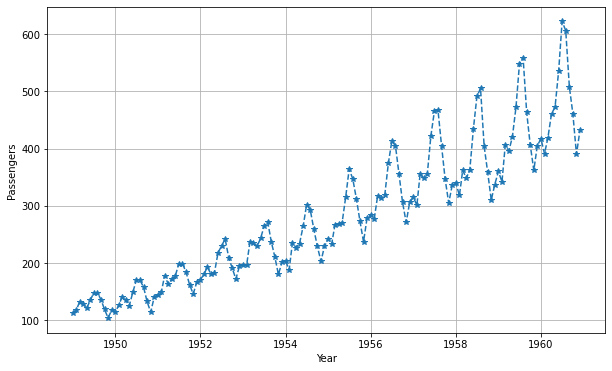

In [15]:
plt.figure(figsize=(10,6))
plt.plot(df.index,df.Passengers,'--',marker='*',)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers')

In [16]:
#check for missing values
df.isnull().values.any()

False

In [17]:
#There are no missing values in our dataset however, in bid to explain how we handle missing values, we will make a copy of our dataset and delete some values at random.
#There are now 14 missing values in the dataset
df_copy = df.copy()
rows = df_copy.sample(frac=0.1,random_state=0)
rows['Passengers'] = np.nan
df_copy.loc[rows.index,'Passengers'] = rows['Passengers']
df_copy.isnull().sum()

Passengers    14
dtype: int64

In [18]:
#Filling missing data by imputation - Forward Fill
df_copy_ffill = df_copy.fillna(method='ffill')
df_copy_ffill.isnull().sum()

Passengers    0
dtype: int64

In [19]:
#Filling missing data by imputation - Backkward Fill
df_copy_bfill = df_copy.fillna(method='bfill')
df_copy_bfill.isnull().sum()

Passengers    0
dtype: int64

In [20]:
#Filling missing data by interpolation
df_copy_LIF = df_copy.interpolate(method='linear',limit_direction='forward')
df_copy_LIF.isnull().sum()
df_copy_LIB = df_copy.interpolate(method='linear',limit_direction='backward')
df_copy_LIB.isnull().sum()

Passengers    0
dtype: int64

In [21]:
#Downsampling and Upsampling

#Downsample to quarterly data points
df_quarterly = df.resample('3M').mean()

#Upsample to daily data points
df_daily = df.resample('D').mean()

In [22]:
df_MA = df.copy()
MA = df_MA['Passengers'].rolling(12).mean()

Time Series Specific Exploratory Methods

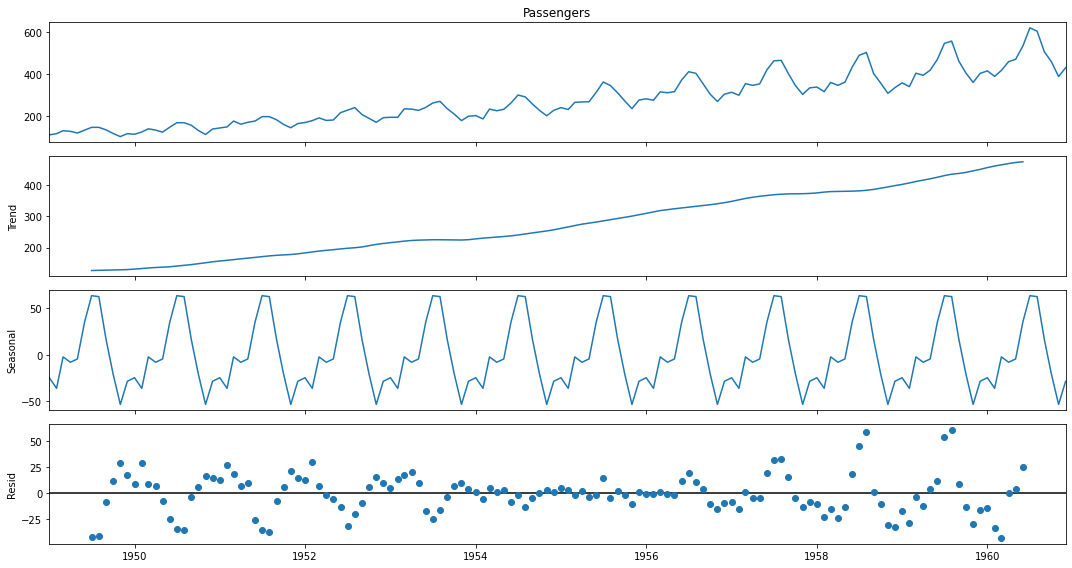

In [23]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
decompose_series = sm.tsa.seasonal_decompose(df['Passengers'],model='additive')
decompose_series.plot()
plt.show()

In [24]:
#The decomposed time series show an obvious increasing trend and seasonality variations.
#Recall that we have initially plotted the moving average on the last 12 months which showed that i varies with time. This suggests that the data is not stationary. We will now perform an ADF test to confirm this speculation.

from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['Passengers'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used: {adf_result[3]}')
print('Critical values:')
for k,v in adf_result[4].items():
      print(f'{k}:{v}')
            

ADF Statistic: 0.8153688792060472
p-value: 0.991880243437641
No. of lags used: 13
No. of observations used: 130
Critical values:
1%:-3.4816817173418295
5%:-2.8840418343195267
10%:-2.578770059171598


In [25]:
#From the results obtained, the p-value is greater than the critical value at a 5% significance level and the ADF statistic is greater that any of the critical values obtain. 
#This confirms that the series is indeed non-stationary.

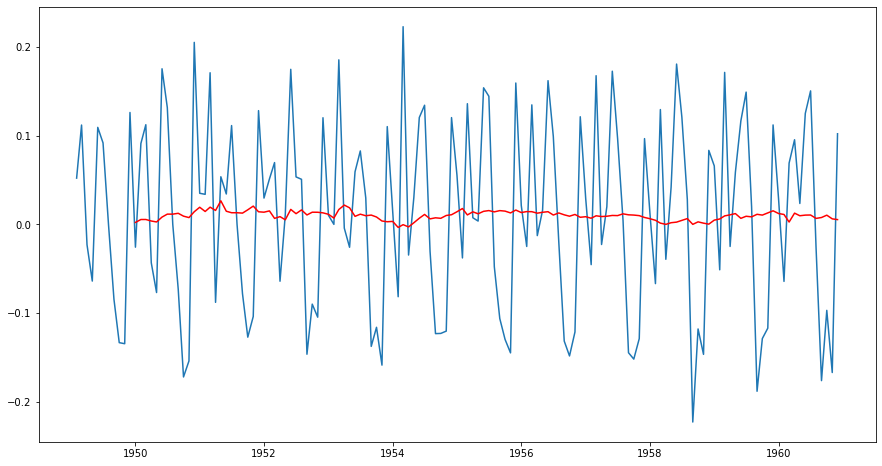

In [26]:
#Convert time series to stationary by removing trend and seasaonlity 
#Transformation and differencing
df_log = np.log(df)
df_diff = df_log.diff(periods=1)
plt.plot(df_diff.index,df_diff.Passengers,'-')
plt.plot(df_diff.rolling(12).mean(),color='red')

Time Series forecasting using stochastic models

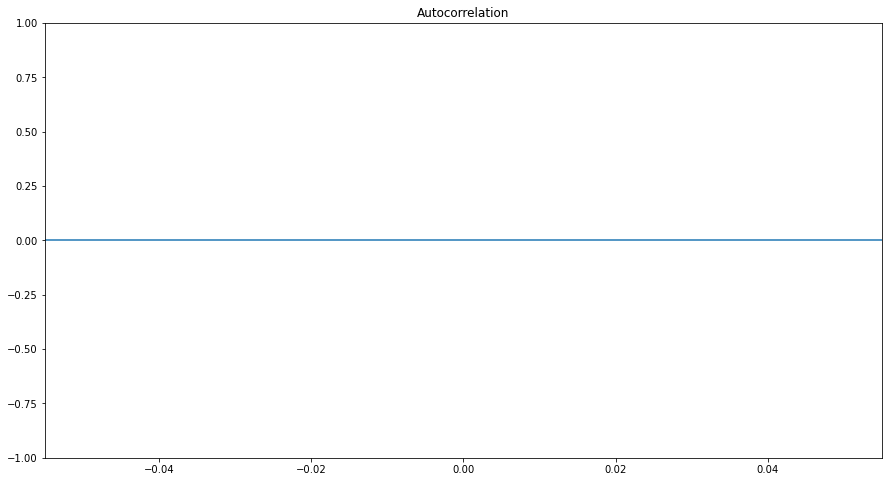

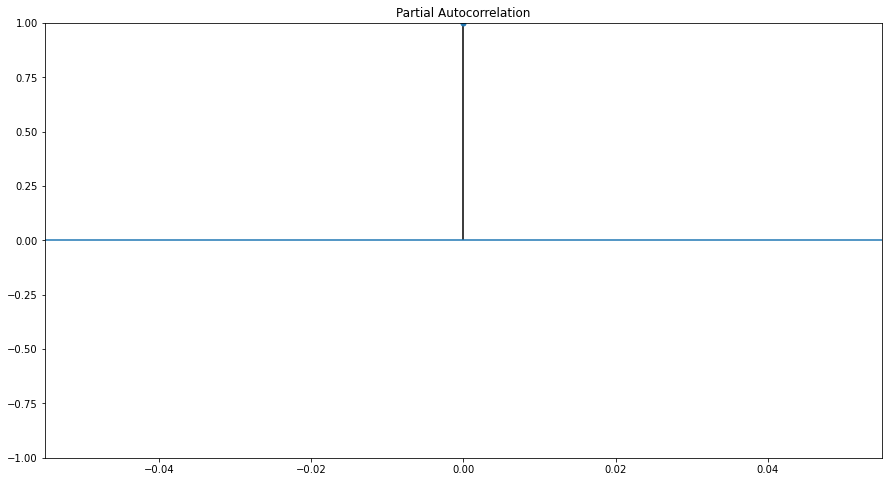

In [27]:
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#ACF
plot_acf(df_diff, lags=range(0,20))
plt.show()
#PACF
plot_pacf(df_diff, lags=range(0,20))
plt.show()

In [29]:
#AR, MA, and ARIMA
from statsmodels.tsa.arima_model import ARIMA
#(p,d,q)
AR_model = ARIMA(df_diff, order=(2,0,0))
AR_model_results = AR_model.fit()
plt.plot(df_diff)
plt.plot(AR_model_results.fittedvalues,color='red')

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [30]:
MA_model = ARIMA(df_diff, order=(0,0,2))
MA_model_results = MA_model.fit()
plt.plot(df_diff)
plt.plot(MA_model_results.fittedvalues,color='red')

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [31]:
ARIMA_model = ARIMA(df_diff,order=(2,0,1))
ARIMA_results = ARIMA_model.fit()
plt.plot(df_diff)
plt.plot(ARIMA_results.fittedvalues,color='red')

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


Time Series at scale

In [35]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.0 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached pystan-3.7.0-py3-none-any.whl (13 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)
  Using cached httpstan-4.10.0-cp38-cp38-macosx_10_15_x86_64.whl (36.0 MB)
  Using cached pysimdjson-5.0.2-cp38-cp38-macosx_10_9_x86_64.whl (193 kB)
  Using cached crashtest-0.3.1-py3-none-any.whl (7.0 kB)
  Using cached pastel-0.2.1-py2.py3-none-any.whl (6.0 kB)
  Using cached pylev-1.4.0-py2.py3-none-any.whl (6.1 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Obtaining dependency information for marshmallow<4.0,>=3.10 from https://files.pythonhosted.org/packages/ed/3c/cebfdcad015240014ff08b883d1c0c427f2ba45ae8c6572851b6ef136cad/marshmallow-3.20.1-py3-none-any.whl.metadata
  Obtaining dependency information for webargs<9.0,>=8.0 from https://files.pythonhos

  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
Failed to build fbprophet
ERROR: Could not build wheels for fbprophet, which is required to install pyproject.toml-based projects
Note: you may need to restart the kernel to use updated packages.


In [37]:
#Time series with facebook prophet
from fbprophet import Prophet
df=pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")

ModuleNotFoundError: No module named 'fbprophet'

Attribute Information:

FullDate: Date in format yyyy-mm-dd  hh:mm:ss
ElecPrice: Prices of electricity charged in Kw per hour
Gas Price: power generated was done via a gas power plant, gas price is the price of gas at time-T
SysLoad: Total Load on system or Power consumed at time-T 
Tmax: maximum temperature at time-T

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('Time_series_analysis_and_forecast_DATASET.csv')
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030
